In [1567]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import re
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import *
from datetime import datetime
from gensim.test.utils import common_texts, get_tmpfile
import multiprocessing
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from tqdm import tqdm
import logging
import multiprocessing
import os
import pprint
import re
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import gensim
from umap import UMAP
from nltk.stem.porter import *
from sklearn.cluster import KMeans
%pylab inline

Populating the interactive namespace from numpy and matplotlib


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Noelia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [1568]:
tweets_user = pd.read_csv('/Users/Noelia/Desktop/DATA_IRONHACK/FINAL_PROJECT/final_project_ironhack/output/User_Noelia/@KimKardashian_tweets.csv')

In [1569]:
tweets_user.head()

,id,created_at,text
0,1158031253632770048,2019-08-04 15:05:40,My #kkwxkylie Lip Set is 40% off for National ...
1,1157837978053443584,2019-08-04 02:17:40,RT @ScottDisick: Make room for the lord this S...
2,1157482389683101696,2019-08-03 02:44:41,You thought we forgot about you??? KKW X KYLIE...
3,1157232435102285824,2019-08-02 10:11:27,"RT @AsyaKardashian: Happy Birthday , Riccardo ..."
4,1157041220528377858,2019-08-01 21:31:38,https://t.co/0Ot4Ej6XHX. https://t.co/HwtEgZTCbF


In [1570]:
tweet_text = tweets_user[['text']]

In [1571]:
def retweet(input_text):
    if input_text.startswith("RT"):
        value = 1
    else:
        value = 0
    return value

In [1572]:
tweets_user['RT'] = tweets_user.text.apply(retweet)

In [1573]:
tweets_user['mention'] = tweets_user.text.str.findall(r'(?<![@\w])@(\w{1,25})').apply(', '.join)

In [1574]:
tweets_user['hashtag'] = tweets_user.text.str.extract(r'(\#\w+)', expand=False)

In [1575]:
tweets_user['hashtag'] = tweets_user['hashtag'].fillna("")

In [1576]:
#def remove_characters(input_text):
#    list_remove = ["RT", "(?<![@\w])@(\w{1,25})", "\#+"]
 #   for charac in list_remove:
  #      input_text = re.sub(charac, '', input_text)
  #  return input_text.lower()
#def remove_special_characters(data, colum):
 #   input_text = data[colum].str.replace("[\d\W_]+", " ", re.UNICODE)
  #  return input_text
#def deEmojify(inputString):
 #   return inputString.encode('latin-1', 'ignore').decode('latin-1')#

In [1577]:
def removeSpace(x):
        return " ".join([w for w in x.split() if len(w)>3])

In [1578]:
#tweets_user['cleaned_tweets'] = tweets_user.text.apply(remove_characters)

In [1579]:
#tweets_user[['cleaned_tweets']].head()

In [1580]:
#tweets_user['cleaned_tweets'] = tweets_user['cleaned_tweets'].str.replace('http\S+|www.\S+', "")

In [1581]:
#tweets_user['cleaned_tweets'] = remove_special_characters(tweets_user, "cleaned_tweets")

In [1582]:
#tweets_user['cleaned_tweets'] = tweets_user['cleaned_tweets'].apply(deEmojify)

In [1583]:
#tweets_user['cleaned_tweets'] = tweets_user['text'].apply(removeSpace)

In [1584]:
tweets_user[['cleaned_tweets']].head()

KeyError: "None of [Index(['cleaned_tweets'], dtype='object')] are in the [columns]"

In [1585]:
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import spacy

In [1586]:
punctuations = string.punctuation
nlp = spacy.load('en')
stop_words = spacy.lang.en.stop_words.STOP_WORDS
parser = English()
def spacy_tokenizer(sentence):
    sentence = remove_characters(sentence)
    #sentence = sentence.replace('http\S+|www.\S+', "")
    mytokens = parser(sentence)
    filtered_tokens = []
    for word in mytokens: 
        lemma = word.lemma_.lower().strip()
        if lemma not in STOP_WORDS and lemma not in punctuations and re.search('[A-Za-z]{2}[A-Za-z]*', lemma) :
            filtered_tokens.append(word)
    return filtered_tokens

In [1587]:
def remove_characters(input_text):
    list_remove = ["RT", "@", "\#+", 'http\S+|www.\S+']
    for charac in list_remove:
        input_text = re.sub(charac, '', input_text)
    return input_text.lower()

In [1588]:
tweets_user['tokenized'] = tweets_user['text'].apply(spacy_tokenizer)

In [1594]:
tweets_user = tweets_user[tweets_user['tokenized'].map(lambda d: len(d)) > 0]

In [1595]:
tweets_user.head()

,id,created_at,text,RT,mention,hashtag,tokenized
0,1158031253632770048,2019-08-04 15:05:40,My #kkwxkylie Lip Set is 40% off for National ...,0,,#kkwxkylie,"[kkwxkylie, lip, set, national, sister, day, e..."
1,1157837978053443584,2019-08-04 02:17:40,RT @ScottDisick: Make room for the lord this S...,1,"ScottDisick, flipitdisick, eentertainment",#FlipItLikeDisick,"[scottdisick, room, lord, sunday, flipitdisick..."
2,1157482389683101696,2019-08-03 02:44:41,You thought we forgot about you??? KKW X KYLIE...,0,kkwfragrance,,"[thought, forgot, kkw, kylie, perfume, coming,..."
3,1157232435102285824,2019-08-02 10:11:27,"RT @AsyaKardashian: Happy Birthday , Riccardo ...",1,AsyaKardashian,,"[asyakardashian, happy, birthday, riccardo, ti..."
5,1156964973488119808,2019-08-01 16:28:39,Get free shipping all month long on all domest...,0,,#kkwbeauty,"[free, shipping, month, long, domestic, orders..."


In [1225]:
#tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)

In [1227]:
#vector2 = bow_vector.fit_transform(all_tweets)

In [642]:
#stopwords_set = set(stopwords.words("english"))
#cleaned_tweets = []
#for index, row in tweets_user.iterrows():
 #   words_without_stopwords = [word for word in row.cleaned_tweets.split() if not word in stopwords_set]
  #  cleaned_tweets.append(' '.join(words_without_stopwords))
#tweets_user['cleaned_tweets'] = cleaned_tweets

In [643]:
tweets_user['date'] = tweets_user['created_at']

In [644]:
tweets_user['date'] = pd.DatetimeIndex(tweets_user['created_at']).to_period('D')

In [645]:
tweets_user = tweets_user.drop(columns=["created_at"], axis=1)

In [646]:
#tweets_user = tweets_user[["id", "date", "mention", "hashtag", "RT", "cleaned_tweets"]]

In [648]:
#def tokenize(s):
    #return s.split(" ") 

In [649]:
stemmer = SnowballStemmer("english")

In [650]:
def tokenize_and_stem(text):
    #first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
     #filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [651]:
tweets_user['tokenized'] = tweets_user['cleaned_tweets'].apply(tokenize_and_stem)

In [652]:
sentences = []
for raw_sentence in tweets_user['tokenized']:
    if len(raw_sentence) > 0:
        sentences.append(raw_sentence)

In [653]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))
print(token_count)

The book corpus contains 15,393 tokens
15393


In [654]:
num_features = 300
min_word_count = 50
num_workers = multiprocessing.cpu_count()
context_size = 10
downsampling = 1e-4
seed = 2

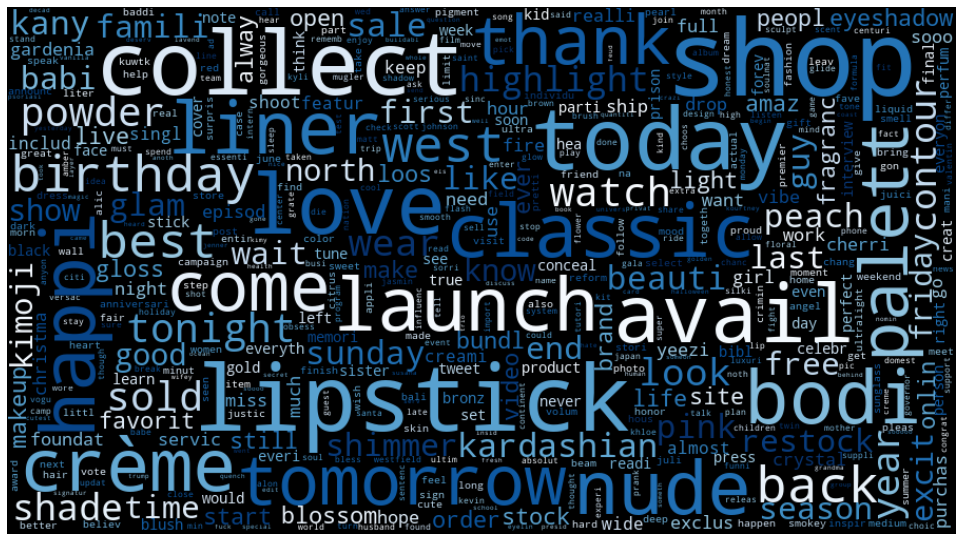

In [655]:
all_words = []
for line in tweets_user['tokenized']: # try 'tokens'
    all_words.extend(line)
    
# create a word frequency dictionary
wordfreq = Counter(all_words)
# draw a Word Cloud with word frequencies
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [656]:
from gensim.models import Word2Vec
from gensim.models import doc2vec
from collections import namedtuple

In [657]:
all_tweets = [row for row in tweets_user['cleaned_tweets']]

In [658]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/Noelia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [659]:
def tokenize_only(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    #filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [660]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in tweets_user['text']:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [661]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print ('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 41374 items in vocab_frame


In [698]:
tweets_user[['cleaned_tweets']].head()

,cleaned_tweets
0,national sister ends tonight
1,make room lord sunday
2,thought forgot kylie perfume coming august che...
3,happy birthday riccardo tisci
5,free shipping month long domestic orders


In [719]:
tweets_user.head()

,id,text,RT,mention,hashtag,cleaned_tweets,date,tokenized
0,1158031253632770048,My #kkwxkylie Lip Set is 40% off for National ...,0,,#kkwxkylie,national sister ends tonight,2019-08-04,"[nation, sister, end, tonight]"
1,1157837978053443584,RT @ScottDisick: Make room for the lord this S...,1,"ScottDisick, flipitdisick, eentertainment",#FlipItLikeDisick,make room lord sunday,2019-08-04,"[make, room, lord, sunday]"
2,1157482389683101696,You thought we forgot about you??? KKW X KYLIE...,0,kkwfragrance,,thought forgot kylie perfume coming august che...,2019-08-03,"[thought, forgot, kyli, perfum, come, august, ..."
3,1157232435102285824,"RT @AsyaKardashian: Happy Birthday , Riccardo ...",1,AsyaKardashian,,happy birthday riccardo tisci,2019-08-02,"[happi, birthday, riccardo, tisci]"
5,1156964973488119808,Get free shipping all month long on all domest...,0,,#kkwbeauty,free shipping month long domestic orders,2019-08-01,"[free, ship, month, long, domest, order]"


In [663]:
all_tweets

['national sister ends tonight',
 'make room lord sunday',
 'thought forgot kylie perfume coming august check page',
 'happy birthday riccardo tisci',
 'free shipping month long domestic orders',
 'date night wearing fire palette',
 'nude crème lipstick peach pink classic icon lipstick free ends tonight',
 'mario look gotten sooo fire collection wanna looks available',
 'filmed documentary working hope learn justice system',
 'last week moved marc howard georgetown professor teaches course inside prison',
 'body shimmer gold sold',
 'update',
 'probably know hair extensions glam teams',
 'body foundation deep dark sold',
 'body shimmer trio sold body shimmers still available shop individually',
 'shop eyeshadow palette juicy gloss love bundle',
 'dudeeee body foundation legit',
 'body foundation sold',
 'body foundation fair sold',
 'body foundation sold shades light medium medium',
 'sunburn video used body foundation shades medium mixed',
 'body foundation sold shade light',
 'body b

In [1261]:
all_tweets_complete = [row for row in tweets_user['text']]

In [1263]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(
                                #max_features=1000,
                                min_df=0.1, 
                                stop_words='english',
                                use_idf=True, tokenizer = spacy_tokenizer, ngram_range=(1,1))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(all_tweets_complete)

print(tfidf_matrix.shape)

/miniconda3/envs/py366/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['3', 'far', 'good', 'little', '\ufeff1'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


CPU times: user 989 ms, sys: 6.02 ms, total: 995 ms
Wall time: 996 ms
(2693, 4)


In [1237]:
array_matrix = tfidf_matrix.toarray()

In [1087]:
'''first_vector_tfidfvectorizer=tfidf_matrix[0]
 
# place tf-idf values in a pandas data frame
df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False)'''

'first_vector_tfidfvectorizer=tfidf_matrix[0]\n \n# place tf-idf values in a pandas data frame\ndf = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])\ndf.sort_values(by=["tfidf"],ascending=False)'

In [1264]:
tfidf_vectorizer.vocabulary_

{'rt': 2, '…': 3, '@kkwbeauty': 0, 'amp': 1}

In [1239]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)
dist

array([[ 0.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [ 1.00000000e+00,  0.00000000e+00,  1.00000000e+00, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [ 1.00000000e+00,  1.00000000e+00, -2.22044605e-16, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       ...,
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
        -2.22044605e-16,  1.00000000e+00,  1.00000000e+00],
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
         1.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
         1.00000000e+00,  1.00000000e+00, -2.22044605e-16]])

In [1091]:
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import umap

In [1240]:
umap = UMAP(n_components=2, n_neighbors=10, metric='cosine')
embedding = umap.fit_transform(vector)

In [1241]:
umap_df = pd.DataFrame(embedding, columns=[f'emb_{i+1}' for i in range(2)])

In [1242]:
umap_df.head()

,emb_1,emb_2
0,-4.075061,-15.129307
1,-5.484497,-11.062606
2,-3.961518,-8.932756
3,-11.930771,-15.429921
4,1.379190,-6.312186


In [858]:
#plt.scatter(umap_df['emb_1'], umap_df['emb_2'], cmap='Spectral', s=5)
#plt.gca().set_aspect('equal', 'datalim')
#plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
#plt.title('UMAP projection', fontsize=12);

In [837]:
from mpl_toolkits.mplot3d import Axes3D

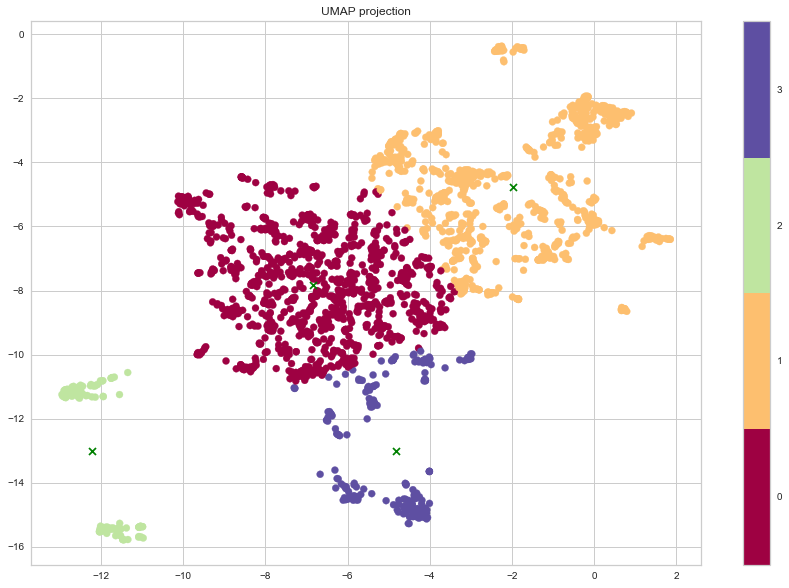

In [1244]:
from matplotlib.pyplot import figure
fig = plt.figure(figsize=(15, 10))
plt.scatter(umap_df['emb_1'], umap_df['emb_2'], c =km.labels_, cmap='Spectral')
#plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(5)-0.5).set_ticks(np.arange(4))
centers = np.array(km.cluster_centers_)

#This array is one dimensional, thus we plot it using:
plt.scatter(centers[:,0], centers[:,1], marker="x", color='green')
plt.title('UMAP projection', fontsize=12);

In [1243]:
from sklearn.cluster import KMeans

num_clusters = 4

km = KMeans(n_jobs=-1, n_clusters=num_clusters)

%time km.fit(embedding)

clusters = km.labels_.tolist()

CPU times: user 15.6 ms, sys: 2.57 ms, total: 18.2 ms
Wall time: 47.5 ms


In [1142]:
predictions = km.fit_predict(embedding)
predictions

array([0, 2, 3, ..., 3, 3, 2], dtype=int32)

In [1143]:
frame['Cluster_predic'] = predictions

In [1245]:
tweets = {'tweet': all_tweets,  'cluster': clusters}
frame = pd.DataFrame(tweets, index = [clusters] , columns = ['tweet', 'cluster'])

In [1248]:
frame[frame['cluster']==2].head()

,tweet,cluster
2,happy birthday riccardo tisci,2
2,love bugs,2
2,love,2
2,sweetest human alive,2
2,sending biggest package ever gonna love,2


In [1146]:
frame['Cluster_predic'] = predictions

In [1147]:
frame.head()

,tweet,cluster,Cluster_predic
2,national sister ends tonight,2,0
1,make room lord sunday,1,2
0,thought forgot kylie perfume coming august che...,0,3
3,happy birthday riccardo tisci,3,1
0,free shipping month long domestic orders,0,3


In [1153]:
frame[frame['Cluster_predic'] == 3]

,tweet,cluster,Cluster_predic
0,thought forgot kylie perfume coming august che...,0,3
0,free shipping month long domestic orders,0,3
0,nude crème lipstick peach pink classic icon li...,0,3
0,mario look gotten sooo fire collection wanna l...,0,3
0,shop eyeshadow palette juicy gloss love bundle,0,3
0,restock alert body collection coming back today,0,3
0,restock alert body collection coming back friday,0,3
0,sign restock updates sold body foundation miss...,0,3
0,sign restock updates sold liquid body shimmer ...,0,3
0,excited guys sooo fire glosses shop,0,3


In [1110]:
tfidf_vectorizer1 = TfidfVectorizer(
                                min_df=1, 
                                stop_words='english',
                                use_idf=True, tokenizer = tokenize_and_stem, ngram_range=(1,2))

In [1112]:
umap = UMAP(n_components=2, n_neighbors=10, metric='cosine')

In [1128]:
token = tokenize_only("i want to buy a pallete and to makeup")
Y = tfidf_vectorizer1.fit_transform(token)
embedding2 = umap.fit_transform(Y)
prediction = km.predict(embedding2)
print(prediction)

#token = tokenize_only("yessss")
Y = tfidf_vectorizer1.fit_transform(['i love my friend and my sister'])
embedding2 = umap.fit_transform(Y)
prediction = km.predict(embedding2)
print(prediction)

[3 3 3 3 3 3 3 3 3]
[1]


/miniconda3/envs/py366/lib/python3.6/site-packages/umap/umap_.py:1385: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "
/miniconda3/envs/py366/lib/python3.6/site-packages/umap/spectral.py:278: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


In [1102]:
frame['cluster'].value_counts()

2    1433
1     894
3     297
0      69
Name: cluster, dtype: int64

In [1103]:
terms = tfidf_vectorizer.get_feature_names()

In [1104]:
tfidf_vectorizer.get_feature_names()

['absolut',
 'actual',
 'ad',
 'album',
 'alic',
 'alic johnson',
 'alic mari',
 'allow',
 'alon',
 'alreadi',
 'alway',
 'amaz',
 'amber',
 'american',
 'angel',
 'anniversari',
 'announc',
 'anoth',
 'answer',
 'anyon',
 'appl',
 'appli',
 'ask',
 'attend',
 'avail',
 'avail onlin',
 'avail purchas',
 'avail shop',
 'avail today',
 'avail tomorrow',
 'award',
 'babe',
 'babi',
 'babi girl',
 'baddi',
 'bali',
 'bday',
 'beam',
 'beauti',
 'begin',
 'believ',
 'bergamot',
 'berri',
 'best',
 'best friend',
 'best nude',
 'best pink',
 'best red',
 'better',
 'bibl',
 'bibl smokey',
 'birthday',
 'birthday beauti',
 'birthday hope',
 'black',
 'black friday',
 'bless',
 'blingi',
 'blossom',
 'blossom collect',
 'blossom palett',
 'blush',
 'bodi',
 'bodi collect',
 'bodi foundat',
 'bodi makeup',
 'bodi shimmer',
 'book',
 'bottl',
 'brand',
 'break',
 'bright',
 'bring',
 'bronz',
 'brother',
 'brown',
 'brush',
 'build',
 'buildabl',
 'bundl',
 'bundl palett',
 'bundl sold',
 'busi'

In [1250]:
km.cluster_centers_

array([[ -6.8486457,  -7.820382 ],
       [ -1.9631443,  -4.7529225],
       [-12.215001 , -13.008707 ],
       [ -4.815679 , -13.000343 ]], dtype=float32)

In [1251]:
print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
order_centroids

Top terms per cluster:



array([[0, 1],
       [0, 1],
       [0, 1],
       [0, 1]])

In [1252]:
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
order_centroids

Top terms per cluster:


array([[0, 1],
       [0, 1],
       [0, 1],
       [0, 1]])

In [1253]:
for i in range(num_clusters):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

print("\n")
print("Prediction")

Cluster 0:
 absolut
 actual
Cluster 1:
 absolut
 actual
Cluster 2:
 absolut
 actual
Cluster 3:
 absolut
 actual


Prediction


In [ ]:
from sklearn.metrics import pairwise_distances_argmin_min
 
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

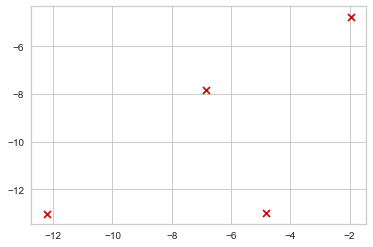

In [1254]:
centers = np.array(km.cluster_centers_)

#This array is one dimensional, thus we plot it using:
plt.scatter(centers[:,0], centers[:,1], marker="x", color='r')

In [ ]:
doc1 = ["This is a sentence", "This is another sentence"]

# Transform data (you can add more data preprocessing steps) 

docs = []
analyzedDocument = namedtuple('AnalyzedDocument', 'words tags')
for i, text in enumerate(sent):
    words = text.lower().split()
    #print(words)
    tags = [i]
   # print(tags)
    docs.append(analyzedDocument(words, tags))
   # print(docs)
Text_INPUT_DIM=100
# Train model (set min_count = 1, if you want the model to work with the provided example data set)

#model = doc2vec.Doc2Vec(size = 300, window = 300, min_count = 1, workers = 4)
model = doc2vec.Doc2Vec(min_count=5, window=5, size=Text_INPUT_DIM, 
                        sample=1e-4, negative=5, workers=4, iter=5,seed=1)




In [ ]:
model.build_vocab(docs)
 #   text_model.save(filename)

In [ ]:
len(docs)

In [ ]:
model.train(docs, total_examples=model.corpus_count, epochs=model.iter)

In [ ]:
model.most_similar('science')

In [ ]:
# Get the vectors
model.docvecs[2300]
#model.docvecs[1]

In [ ]:
X=[]
for i in range(40):
    X.append(model.docvecs[i])

In [ ]:
model.vocabulary

In [ ]:
sent = [row for row in tweets_user['cleaned_tweets']]

In [ ]:
tweet_vocab = []
for e in sent:
        tweet_vocab.append(e)

In [ ]:
model = gensim.models.Word2Vec(min_count=2, size=100,window=2,
                     sample=6e-5, 
                     alpha=0.01, 
                     min_alpha=0.0007,negative=20,
                     workers=cores-1
                              )

In [ ]:
#t = time()

model.build_vocab(data_array, progress_per=10000)

#print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

In [ ]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
#tsne_plot(model)

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)

#print all the labels
print (kmeans.labels_)


In [ ]:
plt.scatter(X[:, 0], X[:, 1], s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [ ]:
from time import time 

In [ ]:
t = time()

model.train(sent, total_examples=model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

In [ ]:
model.wv.most_similar(positive=["engineering"])

In [ ]:
model.wv.similarity("start", 'data')

In [ ]:
word_freq = defaultdict(int)
for sen in sent:
    for e in sen:
        word_freq[e] += 1
len(word_freq)

In [ ]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

In [ ]:
corpus = onehot.fit_transform(corpus.toarray())

In [ ]:
def tsnescatterplot(model, word):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=50).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

In [ ]:
tsnescatterplot(model, sent)

In [ ]:
import multiprocessing

from gensim.models import Word2Vec
cores = multiprocessing.cpu_count() 

In [ ]:
from keras.preprocessing.text import Tokenizer

In [ ]:
from keras.preprocessing.sequence import pad_sequences

In [ ]:
tokenizer_object = Tokenizer()

In [ ]:
tokenizer_object.fit_on_texts(tweets_user['cleaned_tweets'])

In [ ]:
sequences = tokenizer_object.texts_to_sequences(tweets_user['cleaned_tweets'])
#vectorize  the text samples into 2d integer tensor

In [ ]:
#pad sequences
word_index = tokenizer_object.word_index
print('Found {} unique tokens.'. format(len(word_index)))

In [ ]:
labels = []

In [ ]:
label_id = len(word_index)

In [ ]:
for name, i in word_index.items():
    labels.append(i)

In [ ]:
max_length = max([len(s.split()) for s in tweets_user['cleaned_tweets']])

In [ ]:
review_pad = pad_sequences(sequences, maxlen = max_length)
print('Shape of tweet tensor is {}'. format(review_pad.shape))

In [ ]:
num_words = len(word_index)+1

In [ ]:
embedding_dim=100

In [ ]:
embedding_matrix = np.zeros((num_words, embedding_dim))

In [ ]:
for word, i in word_index.items():
    if i < num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] =embedding_vector

In [ ]:
embedding_vector

In [ ]:
print(num_words)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform( tweets_user['cleaned_tweets'])
print(vectorizer.get_feature_names())

In [ ]:
vectorizer.vocabulary_

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.preprocessing import Normalizer

In [ ]:
vectorizer = HashingVectorizer(n_features=20)
vector = vectorizer.transform(tweets_user['cleaned_tweets'])